In [3]:
from gurobipy import Model, GRB, quicksum
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx  
import random

### **Generate Random Demand**

In [4]:
def random_demand(num_demands=4, nodes=None, min_amount=1, max_amount=None, arc_capacity=None):
    if arc_capacity:
            max_capacity = max(arc_capacity.values(), default=max_amount)
            max_amount = min(max_amount, max_capacity) if max_amount else max_capacity

    demand = {}
    
    if arc_capacity:
        max_capacity = max(arc_capacity.values(), default=max_amount)
        max_amount = min(max_amount, max_capacity) if max_amount else max_capacity

    demand = {}
    used_pairs = set() 

    for k in range(1, num_demands + 1):
        while True:
            origin, destination = sorted(random.sample(list(nodes.keys()), 2))  # Ensure direction consistency
            if (origin, destination) not in used_pairs:
                used_pairs.add((origin, destination))  # Mark this pair as used
                break

        amount = random.randint(min_amount, max_amount)  # Randomly select demand amount

        demand[f'k{k}'] = {
            'origin': origin,
            'destination': destination,
            'amount': amount
        }
        
    print("Generated Demand:")
    for k, info in demand.items():
        print(f"  {k}: Origin={info['origin']}, Destination={info['destination']}, Amount={info['amount']}")
        
    return demand

In [5]:
demand = random_demand(num_demands=4, nodes=nodes, min_amount=1, max_amount=10, arc_capacity=arc_capacity)

Generated Demand:
  k1: Origin=n3, Destination=n4, Amount=9
  k2: Origin=n1, Destination=n4, Amount=4
  k3: Origin=n2, Destination=n3, Amount=4
  k4: Origin=n1, Destination=n2, Amount=10


## **Network Topology**


Weighted average shortest distance calculation:
  Weighted sum of shortest distances: 461.78000000000003
  Total demand: 27
  Weighted average shortest distance: 17.102962962962962

Maximum allowable distance (D_k):
D_k = 17.102962962962962


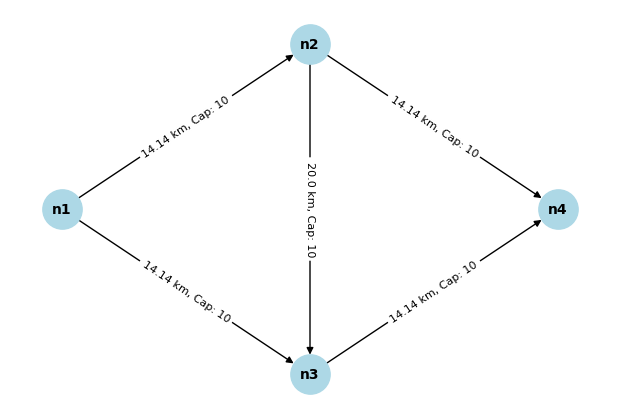

In [6]:
nodes = {
    "n1": (0, 0),
    "n2": (10, 10),
    "n3": (10, -10),
    "n4": (20, 0)
}

edges = {
    'e1': ['n1', 'n2'],
    'e2': ['n1', 'n3'],
    'e3': ['n2', 'n3'],
    'e4': ['n2', 'n4'],
    'e5': ['n3', 'n4']
}

arcs = [(edge[0], edge[1]) for edge in edges.values()]


def euclidean_distance(node1, node2):
    x1, y1 = nodes[node1]
    x2, y2 = nodes[node2]
    return round(((x2 - x1)**2 + (y2 - y1)**2)**0.5, 2)

arc_distance = {tuple(edge): euclidean_distance(edge[0], edge[1]) for edge in arcs}
arc_capacity = {tuple(edge): 10 for edge in arcs}  

#demand = {
#    'k1': {'origin': 'n1', 'destination': 'n4', 'amount': 18},
#    'k2': {'origin': 'n2', 'destination': 'n3', 'amount': 5},
#    'k3': {'origin': 'n1', 'destination': 'n3', 'amount': 7},  
#    'k4': {'origin': 'n3', 'destination': 'n4', 'amount': 6}   
#}

G = nx.DiGraph()
for node, position in nodes.items():
    G.add_node(node, pos=position)
for (u, v) in arcs:
    distance = arc_distance[(u, v)]
    capacity = arc_capacity[(u, v)]
    G.add_edge(u, v, weight=distance, capacity=capacity)

# Calculate weighted average shortest path distance for D_k
weighted_sum = sum(
    nx.shortest_path_length(G, source=info['origin'], target=info['destination'], weight='weight') * info['amount']
    for info in demand.values()
)
total_demand = sum(info['amount'] for info in demand.values())
average_distance = weighted_sum / total_demand

alpha = 1
max_distance = average_distance * alpha

print("\nWeighted average shortest distance calculation:")
print(f"  Weighted sum of shortest distances: {weighted_sum}")
print(f"  Total demand: {total_demand}")
print(f"  Weighted average shortest distance: {average_distance}")

print("\nMaximum allowable distance (D_k):")
print(f"D_k = {max_distance}")


comps_st = {0: 1, 1: 1, 2: 1, 3: 0, 4: 1}  


plt.figure(figsize=(6, 4))
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_size=800, node_color="lightblue", font_size=10, font_weight="bold")
edge_labels = {edge: f"{arc_distance[edge]} km, Cap: {arc_capacity[edge]}" for edge in arcs}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5)
plt.show()

## **MCNF system function**

In [7]:
def MCNF_systemfunc(comps_st, edges, arcs, arc_capacity, demand, arc_distance, max_distance):
    from gurobipy import Model, GRB, quicksum

    # Create Gurobi model
    model = Model("Network Flow Optimization")

    # Define variables
    flow = {}
    unmet_demand = {}
    for k, info in demand.items():
        unmet_demand[k] = model.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"unsatisfied_{k}")
        for i, j in arcs:
            # Determine capacity based on component state
            capacity = arc_capacity.get((i, j), 0) * comps_st[arcs.index((i, j))]
            flow[k, i, j] = model.addVar(lb=0, ub=capacity, vtype=GRB.CONTINUOUS, name=f"flow_{k}_{i}_{j}")

    # Objective function: Minimize the percentage of unmet demand relative to total demand
    total_demand = sum(info['amount'] for info in demand.values())
    model.setObjective(
        (quicksum(unmet_demand[k] for k in demand) / total_demand) * 100, GRB.MINIMIZE
    )
    
    # Extract all nodes from edge values
    nodes = set(node for edge in edges.values() for node in edge)

    # Constraint 1: Flow conservation
    for k, info in demand.items():
        origin = info['origin']
        destination = info['destination']
        amount = info['amount']
        for node in nodes: 
            inflow = quicksum(flow[k, i, j] for i, j in arcs if j == node)
            outflow = quicksum(flow[k, i, j] for i, j in arcs if i == node)
            if node == origin:
                model.addConstr(outflow - inflow == amount - unmet_demand[k])
            elif node == destination:
                model.addConstr(outflow - inflow == -amount + unmet_demand[k])
            else:
                model.addConstr(outflow - inflow == 0)

    # Constraint 2: Arc capacity limits
    for i, j in arcs:
        model.addConstr(quicksum(flow[k, i, j] for k in demand) <= arc_capacity.get((i, j), 0))

    # Constraint 3: Distance limits
    for k, info in demand.items():
        origin = info['origin']
        distance_expr = quicksum(arc_distance.get((i, j), 0) * flow[k, i, j] for i, j in arcs)
        total_flow = quicksum(flow[k, i, j] for i, j in arcs if i == origin)
        model.addConstr(distance_expr <= max_distance * total_flow)

    # Perform optimization
    model.optimize()

    # Process results
    if model.status == GRB.OPTIMAL:
        unmet_demand_percentage = model.objVal 
        flows = {
            k: {arc: flow[k, arc[0], arc[1]].X for arc in arcs} for k in demand
        }
        return unmet_demand_percentage, flows
    else:
        return None, None


### **Operate MCNF systemfunction**

In [8]:
unmet_percentage, flows = MCNF_systemfunc(
    comps_st=comps_st,
    edges=edges,
    arcs=arcs,
    arc_capacity=arc_capacity,
    demand = demand,
    arc_distance=arc_distance,
    max_distance=max_distance
)

if unmet_percentage is not None:
    print(f"Unmet Demand Percentage: {unmet_percentage:.2f}%")
    print("Flow Allocation:")
    for k, flow_dict in flows.items():
        print(f"  Commodity {k}:")
        for arc, flow_value in flow_dict.items():
            if flow_value > 0:
                print(f"    Flow on {arc}: {flow_value:.2f}")
else:
    print("Optimization failed or infeasible.")

Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 5 3600XT 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 25 rows, 24 columns and 88 nonzeros
Model fingerprint: 0x59b8dba1
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [4e+00, 4e+00]
  Bounds range     [1e+01, 1e+01]
  RHS range        [4e+00, 1e+01]
Presolve removed 25 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9629630e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.962962963e+01
Unmet Demand Percentage: 29.63%
Flow Allocation:
  Commodity k1:
    Flow on ('n3', 'n4'): 9.00
  Commodity k2:
  Comm